# Optimization

In this notebook, we explore how the scale of gradient of loss with respect to model parameters changes with layer in feed-forward neural network. It is found that the scale varies greatly between different layers, indicating that a proper optimization algorithm shall employ different learning-rates for different layers.

## Data and Model

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tf.random.set_seed(1234)

Load and process MNIST dataset.

In [ ]:
(ds_train,), ds_info = tfds.load(
    'mnist',
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img)
ds_train = ds_train.batch(128)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def build_model(hidden_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_dim, 'relu'),
        tf.keras.layers.Dense(hidden_dim, 'relu'),
        tf.keras.layers.Dense(10),
    ])

    # Force building the model
    x_batch = tf.random.uniform([128, 28, 28, 1])
    _ = model(x_batch)

    return model

Then define loss and functions for training.

In [ ]:
def cross_entropy_loss(logits, labels):
    """Compute cross entropy loss with a sparse operation."""
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels)
    return tf.reduce_mean(sparse_ce)


def train_step(model, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)
        loss_batch = cross_entropy_loss(y_pred, y_batch)
    grads = tape.gradient(loss_batch, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss_batch

In [ ]:
def get_training_history(model, optimizer, epochs=5, ds=ds_train):
    # Initializations.
    x_batch, y_batch = next(ds.as_numpy_iterator())
    loss_values = [cross_entropy_loss(model(x_batch), y_batch)]
    history = [[var.numpy()] for var in model.variables]

    # Training process.
    for epoch in range(epochs):
        ds_iter = ds.as_numpy_iterator()
        while True:
            try:
                x_batch, y_batch = next(ds_iter)
            except StopIteration:
                break
            loss_batch = train_step(model, optimizer, x_batch, y_batch)
            loss_values.append(loss_batch.numpy())
            for i, var in enumerate(model.variables):
                history[i].append(var.numpy())

    loss_values = np.stack(loss_values)
    history = [np.stack(var_history, axis=0) for var_history in history]
    return loss_values, history

Let us train a model.

In [ ]:
def clone_model(model):
    new_model = tf.keras.models.clone_model(model)
    for i, var in enumerate(model.variables):
        new_model.variables[i].assign(var)
    return new_model

In [ ]:
m1 = build_model(128)
m2 = clone_model(m1)

In [ ]:
sgd_loss, sgd_history = get_training_history(m1, tf.keras.optimizers.SGD())
# rms_loss, rms_history = get_training_history(m2, tf.keras.optimizers.RMSprop())
rms_loss, rms_history = get_training_history(m2, tf.keras.optimizers.Adam())

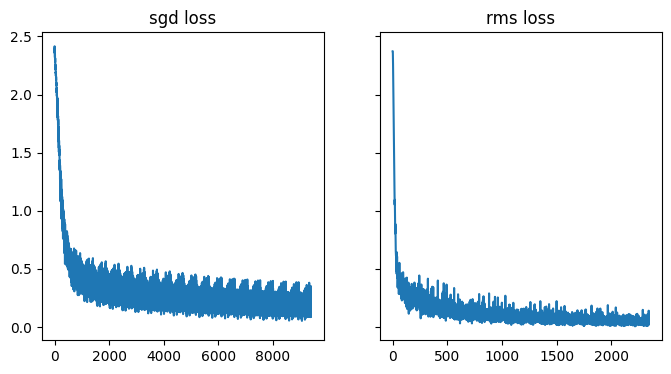

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axs[0].plot(sgd_loss)
axs[0].set_title('sgd loss')
axs[1].plot(rms_loss)
axs[1].set_title('rms loss')
plt.show()

In [ ]:
def plot_elementwise_history(units, histories):
    nrows, ncols = len(units)-1, len(histories)
    fig, axs = plt.subplots(nrows, ncols, figsize=(3*nrows, 3*ncols))
    for i, (m, n) in enumerate(zip(units[:-1], units[1:])):
        for j, history in enumerate(histories):
            data = history[2*i][:, m, n]  # weight at layer i.
            ax = axs[i][j]
            ax.plot(data, label=f'$| \Delta y | = $ {np.abs(np.max(data) - np.min(data)):.3e}')
            ax.grid(True)
            ax.legend()
    return fig

[725, 106, 80, 5]


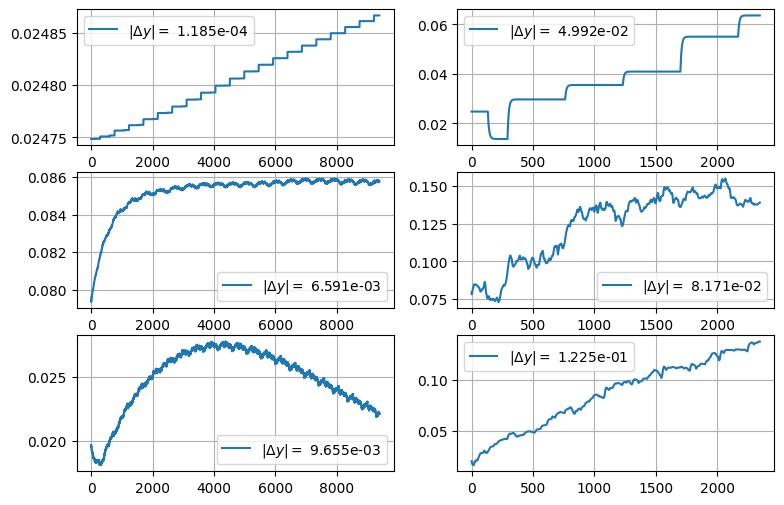

In [ ]:
units = [np.random.randint(784),
         np.random.randint(128),
         np.random.randint(128),
         np.random.randint(10),]
print(units)
plot_elementwise_history(units, [sgd_history, rms_history])
plt.show()